## 異なる強さの正則化(多項式回帰)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

### サンプルデータ１(多項式回帰)

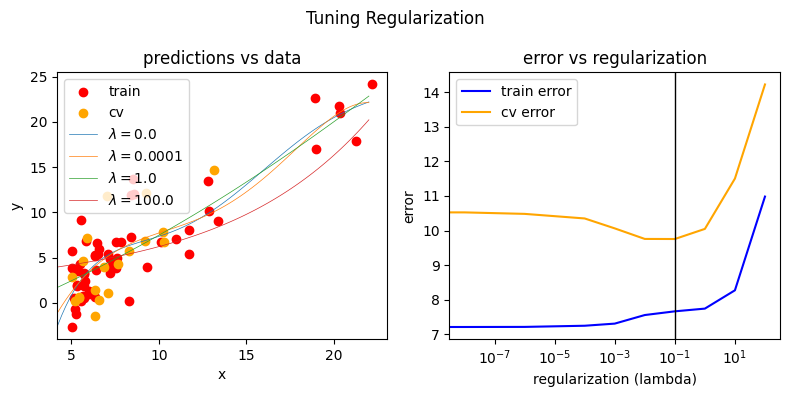

In [ ]:
#データの読み込み
data = pd.read_csv("../datasets/example1.txt")
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
# X.shape (40,) y.shape (40,)
# X_train.shape (24,) y_train.shape (24,)
# X_cv.shape (8,) y_cv.shape (8,)
# X_test.shape (8,) y_test.shape (8,)

lambda_range = np.array([0.0, 1e-8, 1e-6, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 5
err_train = np.zeros(num_steps)    #トレーニング誤差
err_cv = np.zeros(num_steps)       #検証誤差
x = np.linspace(0,int(X.max()),100) #x軸１００等分
y_pred = np.zeros((100,num_steps))  #shape = (100,num_steps)
                                    #Input(shape=(100,)
#多項式回帰
for i in range(num_steps):
    lambda_ = lambda_range[i]
    lmodel = make_pipeline(
        PolynomialFeatures(degree),
        StandardScaler(),
        Ridge(alpha=lambda_, solver='auto')  
    )
    lmodel.fit(X_train, y_train)  # 学習

    # 予測と誤差計算
    yhat_train = lmodel.predict(X_train)
    err_train[i] = np.mean((yhat_train - y_train) ** 2)

    yhat_cv = lmodel.predict(X_cv)
    err_cv[i] = np.mean((yhat_cv - y_cv) ** 2)

    y_pred[:, i] = lmodel.predict(x.reshape(-1, 1))  # xは1次元なのでreshape


fig, ax = plt.subplots(1,2,figsize=(8,4))
fig.suptitle("Tuning Regularization",fontsize = 12)

#比較表示(予測)
ax[0].set_title("predictions vs data",fontsize = 12)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[0].scatter(X_train, y_train, color = "red", label="train")
ax[0].scatter(X_cv, y_cv, color = "orange", label="cv")

ax[0].set_xlim(ax[0].get_xlim()) #後から追加する線のせいで軸が勝手に変わるのを防ぐ
ax[0].set_ylim(ax[0].get_ylim()) #set(min,max)

for i in (0,3,7,9):
    ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
ax[0].legend()


#比較表示(損失)
ax[1].set_title("error vs regularization",fontsize = 12)
ax[1].plot(lambda_range, err_train[:], label="train error", color = "blue")
ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = "orange")
ax[1].set_xscale('log') #x軸対数に
ax[1].set_ylim(*ax[1].get_ylim())
optimal_reg_idx = np.argmin(err_cv) #err_cvのmin
opt_x = lambda_range[optimal_reg_idx]
#垂直線(x,長さ,...)
ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)

ax[1].set_xlabel("regularization (lambda)")
ax[1].set_ylabel("error")
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

### サンプルデータ2(ニューラルネットワーク)

Finished lambda = 1e-10
Finished lambda = 1e-08
Finished lambda = 1e-06
Finished lambda = 0.001
Finished lambda = 0.1


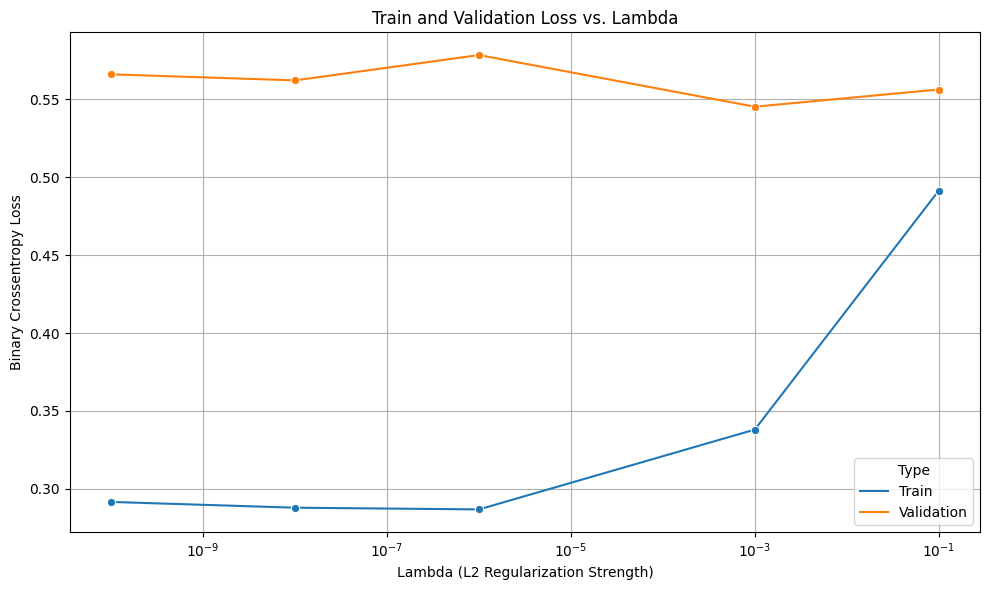

In [4]:
# データの読み込み
df = pd.read_csv("../datasets/train.csv")

# 欠損値の処理
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# カテゴリ変数のエンコーディング
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# 特徴量と目的変数の設定
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']
X = df[features]
y = df['Survived']

# データの分割
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3, random_state=1)


# 特徴量の標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)

tf.random.set_seed(1234)
lambdas = [1e-10 ,1e-8, 1e-6, 1e-3, 1e-1]
models = []
train_losses = []
val_losses = []
val_accuracies = []


for lambda_ in lambdas:
    model = Sequential([
        Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), input_shape=(8,)),
        Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_cv, y_cv) , verbose=0)
    models.append(model)
    train_losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])
    print(f"Finished lambda = {lambda_}")

# 損失をデータフレームにまとめる
df_loss = pd.DataFrame({
    'Lambda': lambdas * 2,  # 各 lambda が 2 回（train, val）出てくる
    'Loss': train_losses + val_losses,
    'Type': ['Train'] * len(lambdas) + ['Validation'] * len(lambdas)
})

import seaborn as sns
# グラフ描画
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_loss, x='Lambda', y='Loss', hue='Type', marker='o')
plt.xticks(lambdas, labels=[str(l) for l in lambdas])  # 軸のラベルをそのまま表示
plt.xscale('log')
plt.title('Train and Validation Loss vs. Lambda')
plt.xlabel('Lambda (L2 Regularization Strength)')
plt.ylabel('Binary Crossentropy Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

